<a href="https://colab.research.google.com/github/vikas-hkk/Lild4o0d8/blob/main/nlp2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
# ============================================================
# 0.  Setup
# ============================================================
!pip -q install fasttext lightgbm nltk tqdm gensim

import numpy as np, pandas as pd, re, random, fasttext, lightgbm as lgb
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing  import LabelEncoder
from sklearn.metrics        import f1_score, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import nltk, warnings, os, gc, sys, gensim
warnings.filterwarnings('ignore')

SEED = 42
random.seed(SEED); np.random.seed(SEED)

# ------------------------------------------------------------
#  Download WordNet once; skip augmentation if download fails
# ------------------------------------------------------------
AUG_PER_SAMPLE = 1          # set 0 to disable augmentation
try:
    for pkg in ("wordnet", "omw-1.4"):
        nltk.data.find(f"corpora/{pkg}")
except LookupError:
    try:
        nltk.download("wordnet", quiet=True); nltk.download("omw-1.4", quiet=True)
    except:
        print("No internet -> synonym augmentation disabled"); AUG_PER_SAMPLE = 0
from nltk.corpus import wordnet

# ============================================================
# 1.  Load & clean data
# ============================================================
df = pd.read_csv('/kaggle/input/nlp-financial-news-sentiment-analysis-dataset/Copy of combined_data(1)05_04_2025.csv')[['Sentence','Sentiment']].dropna()
def clean(txt):
    txt = re.sub(r'[^\w\s]', ' ', str(txt))
    return re.sub(r'\s+', ' ', txt).lower().strip()
df['clean'] = df['Sentence'].apply(clean)

# Normalize sentiment labels
df['Sentiment'] = df['Sentiment'].str.lower().str.strip()
print("Class counts before augmentation:\n", df['Sentiment'].value_counts(), '\n')

# ============================================================
# 2.  Easy‑Data‑Augmentation (optional)
# ============================================================
NEG_LABEL = 'negative'
AUG_PER_SAMPLE = 0
def synonym_swap(sentence):
    words = sentence.split()
    idxs  = [i for i, w in enumerate(words) if wordnet.synsets(w)]
    if not idxs: return sentence
    i = random.choice(idxs)
    syn = [l.name().replace('_',' ') for l in wordnet.synsets(words[i])]
    syn = [s for s in syn if s != words[i]]
    if not syn: return sentence
    words[i] = random.choice(syn)
    return ' '.join(words)

if AUG_PER_SAMPLE > 0:
    aug = [{'Sentence': s,
            'Sentiment': NEG_LABEL,
            'clean': synonym_swap(clean(s))}
           for s in df.loc[df.Sentiment == NEG_LABEL, 'Sentence']
           for _ in range(AUG_PER_SAMPLE)]
    df = pd.concat([df, pd.DataFrame(aug)], ignore_index=True)
    print("After augmentation:\n", df['Sentiment'].value_counts(), '\n')

# ============================================================
# 3.  fastText Wiki News Subwords 300‑d embeddings using Gensim
# ============================================================
print("Loading fastText Wiki News Subwords 300 model…")
# Adjust the path if necessary – ensure this dataset is attached to your notebook.
kv = gensim.models.KeyedVectors.load_word2vec_format(
    '/kaggle/input/wikinews300d1msubwordvec/wiki-news-300d-1M-subword.vec', binary=False)

def sent_vec(text):
    words = text.split()
    vecs = [kv[w] for w in words if w in kv]
    if vecs:
        return np.mean(vecs, axis=0)
    else:
        return np.zeros(kv.vector_size)

X = np.vstack([sent_vec(t) for t in tqdm(df['clean'], desc='Embedding')])
print("Embedding shape:", X.shape)

# ============================================================
# 4.  Labels & stratified split
# ============================================================
le = LabelEncoder(); y = le.fit_transform(df['Sentiment'])
print("\nAll sentiment labels in the dataset:", le.classes_)
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, stratify=y, random_state=SEED)

# ============================================================
# 5.  Class weights
# ============================================================
cw = compute_class_weight('balanced', classes=np.unique(y_tr), y=y_tr)
cw_dict = {c: w for c, w in zip(np.unique(y_tr), cw)}
sample_w = np.array([cw_dict[i] for i in y_tr])
print("Class weights:", {le.inverse_transform([k])[0]: f"{v:.2f}" for k, v in cw_dict.items()})

# ============================================================
# 6.  LightGBM training with early stopping callback
# ============================================================
params = dict(objective='multiclass', num_class=3, learning_rate=0.08,
              num_leaves=31, feature_fraction=0.9,
              lambda_l1=0.1, lambda_l2=0.1,
              metric='None', verbose=-1, seed=SEED)

def macro_f1(preds, data):
    y_true = data.get_label()
    y_pred = preds.reshape(3, -1).T.argmax(1)
    return 'macro_f1', f1_score(y_true, y_pred, average='macro'), True

dtrain = lgb.Dataset(X_tr, label=y_tr, weight=sample_w)
dvalid = lgb.Dataset(X_te, label=y_te)
model  = lgb.train(params, dtrain, 400, valid_sets=[dvalid],
                   feval=macro_f1,
                   callbacks=[lgb.early_stopping(stopping_rounds=30), lgb.log_evaluation(period=50)])

# ============================================================
# 7.  Threshold tuning (boost NEGATIVE prob.)
# ============================================================
proba_val = model.predict(X_te, num_iteration=model.best_iteration)
neg_idx   = list(le.classes_).index(NEG_LABEL)

best_f1, best_t = 0, 1.0
for t in np.linspace(0.4, 1.6, 25):
    adj = proba_val.copy()
    adj[:, neg_idx] *= t
    f1  = f1_score(y_te, adj.argmax(1), average='macro')
    if f1 > best_f1: best_f1, best_t = f1, t

print(f"\nBest negative‑scale = {best_t:.2f}  →  macro‑F1 = {best_f1:.4f}")

final_pred = (proba_val * np.array([best_t if i==neg_idx else 1 for i in range(3)])).argmax(1)
print("\n=== Test‑set report ===")
print(classification_report(y_te, final_pred, target_names=le.classes_))
print("Confusion:\n", confusion_matrix(y_te, final_pred))

# ============================================================
# 8.  Inference helper
# ============================================================
def predict_sentences(sent_list):
    vecs  = np.vstack([sent_vec(clean(s)) for s in sent_list])
    proba = model.predict(vecs) * np.array([best_t if i==neg_idx else 1 for i in range(3)])
    return le.inverse_transform(proba.argmax(1))

# --- quick demo ---
demo = ["Revenues plunged 30 percent and the outlook was cut again.",
        "The company beat analyst expectations and shares soared 8%.",
        "Management reaffirmed full‑year guidance, keeping forecasts unchanged."]
for s, l in zip(demo, predict_sentences(demo)):
    print(f"{l.upper():8} | {s}")


Class counts before augmentation:
 Sentiment
neutral     6009
positive    3431
negative    1647
Name: count, dtype: int64 

Loading fastText Wiki News Subwords 300 model…


Embedding: 100%|██████████| 11087/11087 [00:00<00:00, 14874.59it/s]


Embedding shape: (11087, 300)

All sentiment labels in the dataset: ['negative' 'neutral' 'positive']
Class weights: {'negative': '2.24', 'neutral': '0.62', 'positive': '1.08'}
Training until validation scores don't improve for 30 rounds
[50]	valid_0's macro_f1: 0.32856
[100]	valid_0's macro_f1: 0.336685
[150]	valid_0's macro_f1: 0.339296
Early stopping, best iteration is:
[156]	valid_0's macro_f1: 0.341014

Best negative‑scale = 1.10  →  macro‑F1 = 0.7849

=== Test‑set report ===
              precision    recall  f1-score   support

    negative       0.61      0.67      0.64       330
     neutral       0.89      0.86      0.88      1202
    positive       0.83      0.84      0.84       686

    accuracy                           0.83      2218
   macro avg       0.78      0.79      0.78      2218
weighted avg       0.83      0.83      0.83      2218

Confusion:
 [[ 221   53   56]
 [ 105 1038   59]
 [  34   75  577]]
NEGATIVE | Revenues plunged 30 percent and the outlook was cut aga

In [ ]:
# Define your new unseen sentence
#new_sentence = """NEW YORK, April 3, 2025 /PRNewswire/ -- In a stark and alarming development, Global Industries reported its worst quarterly performance in over 15 years. Revenues dropped by nearly 40% amid an intensifying economic slowdown and escalating operational costs. Company executives admitted that persistent supply chain disruptions and a severe decline in consumer confidence have critically undermined their competitive position. The stock market reacted harshly, with shares falling 30% in after-hours trading. Analysts warn that without urgent corrective measures, the firm may face insolvency, igniting widespread concerns among investors about the future viability of the business."""
new_sentence="""IRVINE, Calif., May 7, 2020 /PRNewswire/ --Coala Life, the Swedish innovator in remote cardiac and respiratory monitoring, and Perry Community Hospital of Tennessee are jointly launching the Perry Virtual remote monitoring program to help improve outcomes for rural Americans. (PRNewsfoto/Coala Life, Inc.) More than 46 million Americans, or 15% of the US population, live in rural areas, according to the CDC. Rural Americans face numerous cardiovascular and respiratory health threats as opposed to those in metropolitan areas. Prevalence of COPD among rural residents is almost double that of most urban areas"""
# Use the inference helper function to predict the sentiment
predicted_label = predict_sentences([new_sentence])

# Print the predicted sentiment
print("Predicted Sentiment:", predicted_label[0])


Predicted Sentiment: neutral


In [ ]:
# Load your CSV file that contains the "generated_summary" column
df_new = pd.read_csv("/kaggle/input/finbert-score/finbert_scored_normalized.csv")  # adjust file path if needed

# Ensure the generated_summary column is a string and clean it using your cleaning function
df_new['generated_summary'] = df_new['generated_summary'].astype(str).apply(clean)

# Use the predict_sentences helper to predict sentiment for each row.
# We assume predict_sentences takes a list of texts and returns a list of sentiment labels.
df_new['sentiment_value'] = predict_sentences(df_new['generated_summary'].tolist())

# Optionally, display the first few rows to verify
print(df_new[['generated_summary', 'sentiment_value']].head())

# Save the updated dataframe to a new CSV file
df_new.to_csv("your_file_with_sentiment.csv", index=False)


                                   generated_summary sentiment_value
0  xi an china march 13 2020 prnewswire longi gre...        positive
1  new york and tel aviv israel march 16 2020 prn...        positive
2  new york march 17 2020 prnewswire today fortun...         neutral
3  london march 18 2020 prnewswire softiron ltd t...        positive
4  austin texas march 19 2020 prnewswire vyopta i...         neutral


In [ ]:
# ============================================================
# 0. install & import
# ============================================================
!pip -q install scikit-learn pandas tqdm nltk

import pandas as pd, numpy as np, re, random, nltk, warnings
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
warnings.filterwarnings('ignore')
nltk.download('stopwords', quiet=True)

SEED = 42
random.seed(SEED); np.random.seed(SEED)

# ------------------------------------------------------------
# 1. load & clean
# ------------------------------------------------------------
df = pd.read_csv("/kaggle/input/nlp-financial-news-sentiment-analysis-dataset/Copy of combined_data(1)05_04_2025.csv")[['Sentence','Sentiment']].dropna()
def clean(t): return re.sub(r'\s+',' ',re.sub(r'[^\w\s]',' ',str(t))).lower().strip()
df['clean'] = df['Sentence'].apply(clean)
df['Sentiment'] = df['Sentiment'].str.lower().str.strip()
print("Class distribution:\n", df['Sentiment'].value_counts(), '\n')

# ------------------------------------------------------------
# 2. tf‑idf (word 1‑4, char 3‑5)
# ------------------------------------------------------------
tfidf = TfidfVectorizer(
        analyzer='word', ngram_range=(1,4),
        min_df=2, stop_words='english', sublinear_tf=True)
X_word = tfidf.fit_transform(df['clean'])

# optional character n‑grams
tfidf_char = TfidfVectorizer(
        analyzer='char', ngram_range=(3,5),
        min_df=2, sublinear_tf=True)
X_char = tfidf_char.fit_transform(df['clean'])

from scipy.sparse import hstack
X = hstack([X_word, X_char]).tocsr()
print("Final TF‑IDF matrix shape:", X.shape)

# ------------------------------------------------------------
# 3. labels & class weights
# ------------------------------------------------------------
label_map = {'negative':0,'neutral':1,'positive':2}
y = df['Sentiment'].map(label_map).values
cw = compute_class_weight('balanced', classes=np.unique(y), y=y)
class_w = {i:w for i,w in zip(np.unique(y), cw)}
print("Class weights:", class_w)

# ------------------------------------------------------------
# 4. train / val / test split
# ------------------------------------------------------------
X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=0.3, stratify=y, random_state=SEED)
X_val,  X_test, y_val,  y_test  = train_test_split(
        X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=SEED)

# ------------------------------------------------------------
# 5. linear‑svm + probability calibration
# ------------------------------------------------------------
base_svm = LinearSVC(C=4.0, class_weight=class_w, random_state=SEED)
svm_cal  = CalibratedClassifierCV(base_svm, cv=5, method='sigmoid')
svm_cal.fit(X_train, y_train)

# ------------------------------------------------------------
# 6. threshold tuning (boost negative)
# ------------------------------------------------------------
NEG_IDX = 0
proba_val = svm_cal.predict_proba(X_val)
best_f1, best_t = 0, 1.0
for t in np.linspace(0.4, 2.0, 33):
    adj = proba_val.copy()
    adj[:,NEG_IDX] *= t
    preds = adj.argmax(1)
    f1 = f1_score(y_val, preds, average='macro')
    if f1 > best_f1:
        best_f1, best_t = f1, t
print(f"Best neg‑scale={best_t:.2f}  macro‑F1={best_f1:.4f}")

# ------------------------------------------------------------
# 7. evaluation on held‑out test set
# ------------------------------------------------------------
proba_test = svm_cal.predict_proba(X_test)
pred_test  = (proba_test * np.array([best_t,1,1])).argmax(1)
print("\n=== Test report ===")
print(classification_report(y_test, pred_test,
      target_names=['negative','neutral','positive']))
print("Confusion matrix:\n", confusion_matrix(y_test, pred_test))

# ------------------------------------------------------------
# 8. inference helper
# ------------------------------------------------------------
def predict_sentiment(text):
    vec  = hstack([
        tfidf.transform([clean(text)]),
        tfidf_char.transform([clean(text)])
    ])
    p    = svm_cal.predict_proba(vec)[0]
    p[NEG_IDX] *= best_t
    return ['negative','neutral','positive'][p.argmax()]

print("\nDemo:",predict_sentiment("Shares plunged 12 percent after the company cut guidance again."))
#in this code we are using the tfidf or ngrams method or both ?? explain this wroking methodology of this code detailly indepth research level

Class distribution:
 Sentiment
neutral     6009
positive    3431
negative    1647
Name: count, dtype: int64 

Final TF‑IDF matrix shape: (11087, 239731)
Class weights: {0: 2.24387775753896, 1: 0.6150219115770789, 2: 1.0771398037501214}
Best neg‑scale=2.00  macro‑F1=0.7936

=== Test report ===
              precision    recall  f1-score   support

    negative       0.58      0.66      0.62       247
     neutral       0.86      0.87      0.86       902
    positive       0.87      0.80      0.84       515

    accuracy                           0.82      1664
   macro avg       0.77      0.78      0.77      1664
weighted avg       0.82      0.82      0.82      1664

Confusion matrix:
 [[162  55  30]
 [ 89 781  32]
 [ 28  73 414]]

Demo: negative


In [ ]:
# =============================================================
# 9. batch‑predict on new CSV and save results
# =============================================================
input_path  = "/kaggle/input/finbert-score/finbert_scored_normalized.csv"    # ← point this at your file
output_path = "/kaggle/working/sentiment_scores.csv"

df_new = pd.read_csv(input_path)

# 9.1 clean the raw sentences
#    (make sure the column name matches your CSV)
df_new['clean'] = df_new['generated_summary'].apply(clean)

# 9.2 vectorize the cleaned text
Xw_new = tfidf.transform(df_new['clean'])
Xc_new = tfidf_char.transform(df_new['clean'])
X_new  = hstack([Xw_new, Xc_new]).tocsr()

# 9.3 predict probabilities and boost the negative class
proba_new = svm_cal.predict_proba(X_new)
proba_new[:, NEG_IDX] *= best_t

# 9.4 map to label names
labels = ['negative','neutral','positive']
df_new['tfidf_sentiment'] = [ labels[i] for i in proba_new.argmax(axis=1) ]

# 9.5 drop the helper column if you like
df_new.drop(columns=['clean'], inplace=True)

# 9.6 write out
df_new.to_csv(output_path, index=False)
print(f"Predictions written to {output_path}")


Predictions written to /kaggle/working/sentiment_scores.csv


FAST TEXT 10 DAYS

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed



Data shape after indicator computation and feature selection: (768, 7)
Sentiment value counts (after normalization):
 Sentiment_Label
 0.0    759
-1.0      6
 1.0      3
Name: count, dtype: int64
Training sequences shape: (698, 60, 7) (698, 10)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.1765
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0153
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0043
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0029
Epoch 5/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0031
Epoch 6/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0028
Epoch 7/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0026
Epoch 8/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0025
Epoch 9/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0025
Epoch 10/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0026
Epoch 11/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0024
Epoch 12/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0022
Epoch 13/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0024
Epoch 14/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0025
Epoch 15/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0024
Epo

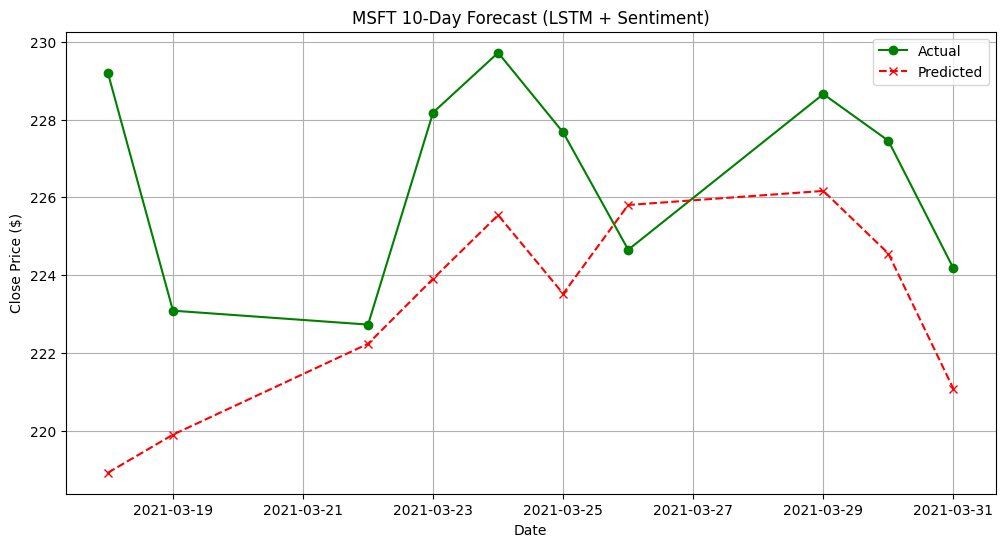

In [ ]:
# ============================================================
# 0.  Setup
# ============================================================
!pip install -q yfinance scikit-learn tensorflow matplotlib numpy

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from math import sqrt

# Set random seed for reproducibility
np.random.seed(42)

# ============================================================
# 1.  Download and prepare MSFT data
# ============================================================
df = yf.download('MSFT', start='2018-01-01', end='2021-04-01')
# Check if data is downloaded
if df.empty:
    raise ValueError("No data was downloaded from yfinance.")

# ============================================================
# 2.  Calculate technical indicators
# ============================================================
def calculate_indicators(df):
    df['SMA_20'] = df['Close'].rolling(20).mean()
    df['SMA_50'] = df['Close'].rolling(50).mean()
    delta = df['Close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(14).mean()
    avg_loss = loss.rolling(14).mean()
    rs = avg_gain / avg_loss
    df['RSI'] = 100 - (100 / (1 + rs))
    df['MACD'] = df['Close'].ewm(span=12).mean() - df['Close'].ewm(span=26).mean()
    df['OBV'] = (np.sign(df['Close'].diff()) * df['Volume']).fillna(0).cumsum()
    return df.dropna()

df = calculate_indicators(df)

# ============================================================
# 3.  Incorporate sentiment labels (categorical: negative, neutral, positive)
# ============================================================
# Define a dictionary mapping dates (YYYY-MM-DD) to sentiment labels.
sentiment_labels = {
    '2021-03-17': 'positive',
    '2021-03-18': 'negative',
    '2021-03-19': 'positive',
    '2021-03-22': 'negative',
    '2021-03-23': 'negative',
    '2021-03-24': 'negative',
    '2021-03-25': 'positive',
    '2021-03-26': 'negative',
    '2021-03-29': 'negative',
    '2021-03-31': 'neutral'
}
# Map sentiment labels to numeric values: negative -> -1, neutral -> 0, positive -> 1
sentiment_map = {'negative': -1, 'neutral': 0, 'positive': 1}

# Create a new column "Sentiment_Label" initialized to 0
df['Sentiment_Label'] = 0.0
date_strs = df.index.strftime('%Y-%m-%d')
for date, label in sentiment_labels.items():
    matching = (date_strs == date)
    df.loc[matching, 'Sentiment_Label'] = sentiment_map[label]

# ============================================================
# 4.  Select features and drop missing values
# ============================================================
features = ['Close', 'SMA_20', 'SMA_50', 'RSI', 'MACD', 'OBV', 'Sentiment_Label']
df = df[features].dropna()
print("\nData shape after indicator computation and feature selection:", df.shape)
print("Sentiment value counts (after normalization):\n", df['Sentiment_Label'].value_counts())

# ============================================================
# 5.  Scale data
# ============================================================
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

# ============================================================
# 6.  Prepare training sequences for LSTM
# ============================================================
# We use 60 days of history to forecast the next 10 days (target: Close price)
X, y, dates = [], [], []
for i in range(60, len(scaled_data) - 10):
    X.append(scaled_data[i-60:i])
    y.append(scaled_data[i:i+10, 0])  # target: Close price (first column)
    dates.append(df.index[i+10])
X, y = np.array(X), np.array(y)
print("Training sequences shape:", X.shape, y.shape)

# ============================================================
# 7.  Build and train the LSTM model
# ============================================================
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X.shape[1], X.shape[2])),
    Dropout(0.2),
    LSTM(32),
    Dense(10)
])
model.compile(optimizer='adam', loss='mse')
model.fit(X, y, epochs=100, batch_size=32, verbose=1)

# ============================================================
# 8.  Forecast: Predict next 10 days from a given target date
# ============================================================
target_date = '2021-03-17'
date_strs = df.index.strftime('%Y-%m-%d')
if target_date in date_strs:
    idx = np.where(date_strs == target_date)[0][0]
else:
    raise ValueError("Target date not found in data index.")
input_sequence = scaled_data[idx-59:idx+1].reshape(1, 60, X.shape[2])
forecast_scaled = model.predict(input_sequence)[0]

# ============================================================
# 9.  Inverse transform for Close only
# ============================================================
def inverse_transform(pred_scaled):
    dummy = np.zeros((10, len(features)))
    dummy[:, 0] = pred_scaled
    return scaler.inverse_transform(dummy)[:, 0]

forecast_prices = inverse_transform(forecast_scaled)

# ============================================================
# 10. Actual prices for comparison (first 10 business days after target_date)
# ============================================================
actual_prices = df.loc[target_date:]['Close'].values[:10]
forecast_dates = pd.date_range(start=pd.to_datetime(target_date) + pd.Timedelta(days=1), periods=10, freq='B')

# ============================================================
# 11.  Evaluation
# ============================================================
mae = mean_absolute_error(actual_prices, forecast_prices)
rmse = sqrt(mean_squared_error(actual_prices, forecast_prices))
r2 = r2_score(actual_prices, forecast_prices)
mape = np.mean(np.abs((actual_prices - forecast_prices) / actual_prices)) * 100

print("\n=== Evaluation ===")
print(f"MAE  = ${mae:.2f}")
print(f"RMSE = ${rmse:.2f}")
print(f"R²   = {r2:.4f}")
print(f"MAPE = {mape:.2f}%")

plt.figure(figsize=(12, 6))
plt.plot(forecast_dates, actual_prices, 'go-', label='Actual')
plt.plot(forecast_dates, forecast_prices, 'rx--', label='Predicted')
plt.title('MSFT 10-Day Forecast (LSTM + Sentiment)')
plt.xlabel('Date')
plt.ylabel('Close Price ($)')
plt.legend()
plt.grid(True)
plt.show()

TFIDF

[*********************100%***********************]  1 of 1 completed


Data shape after indicator computation and feature selection: (768, 7)
Sentiment value counts (after normalization):
 Sentiment_Label
0.0    762
1.0      6
Name: count, dtype: int64
Training sequences shape: (698, 60, 7) (698, 10)
Epoch 1/100



/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.1719
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0081
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0036
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0032
Epoch 5/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0031
Epoch 6/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0030
Epoch 7/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0031
Epoch 8/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0027
Epoch 9/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0028
Epoch 10/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0025
Epoch 11/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0024
Epoch 12/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0027
Epoch 13/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0025
Epoch 14/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0022
Epoch 15/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0025
Epoch 16/100
2

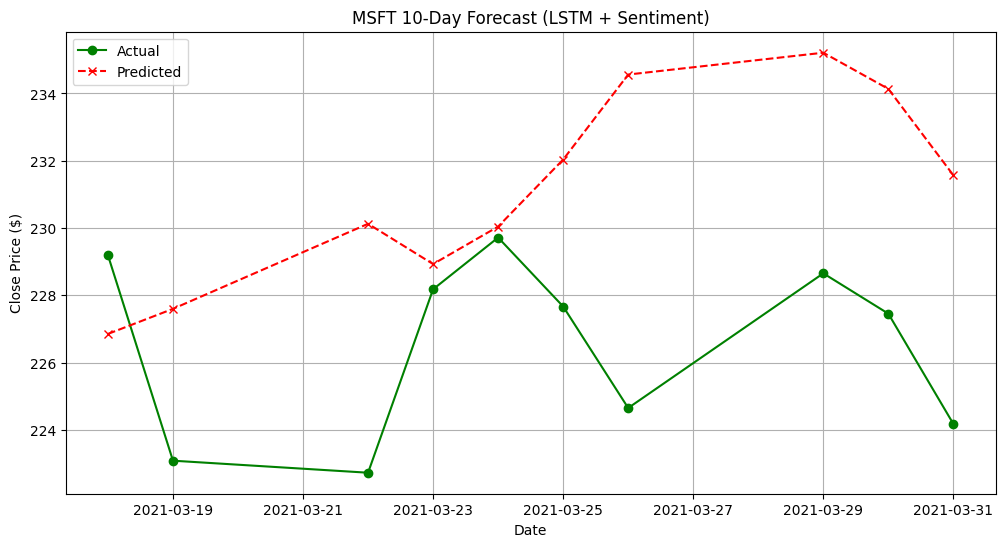

In [ ]:
# ============================================================
# 0.  Setup
# ============================================================
!pip install -q yfinance scikit-learn tensorflow matplotlib numpy

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from math import sqrt

# Set random seed for reproducibility
np.random.seed(42)

# ============================================================
# 1.  Download and prepare MSFT data
# ============================================================
df = yf.download('MSFT', start='2018-01-01', end='2021-04-01')
# Check if data is downloaded
if df.empty:
    raise ValueError("No data was downloaded from yfinance.")

# ============================================================
# 2.  Calculate technical indicators
# ============================================================
def calculate_indicators(df):
    df['SMA_20'] = df['Close'].rolling(20).mean()
    df['SMA_50'] = df['Close'].rolling(50).mean()
    delta = df['Close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(14).mean()
    avg_loss = loss.rolling(14).mean()
    rs = avg_gain / avg_loss
    df['RSI'] = 100 - (100 / (1 + rs))
    df['MACD'] = df['Close'].ewm(span=12).mean() - df['Close'].ewm(span=26).mean()
    df['OBV'] = (np.sign(df['Close'].diff()) * df['Volume']).fillna(0).cumsum()
    return df.dropna()

df = calculate_indicators(df)

# ============================================================
# 3.  Incorporate sentiment labels (categorical: negative, neutral, positive)
# ============================================================
# Define a dictionary mapping dates (YYYY-MM-DD) to sentiment labels.
sentiment_labels = {
    '2021-03-17': 'positive',
    '2021-03-18': 'neutral',
    '2021-03-19': 'positive',
    '2021-03-22': 'neutral',
    '2021-03-23': 'positive',
    '2021-03-24': 'neutral',
    '2021-03-25': 'neutral',
    '2021-03-26': 'positive',
    '2021-03-29': 'positive',
    '2021-03-31': 'positive'
}
# Map sentiment labels to numeric values: negative -> -1, neutral -> 0, positive -> 1
sentiment_map = {'negative': -1, 'neutral': 0, 'positive': 1}

# Create a new column "Sentiment_Label" initialized to 0
df['Sentiment_Label'] = 0.0
date_strs = df.index.strftime('%Y-%m-%d')
for date, label in sentiment_labels.items():
    matching = (date_strs == date)
    df.loc[matching, 'Sentiment_Label'] = sentiment_map[label]

# ============================================================
# 4.  Select features and drop missing values
# ============================================================
features = ['Close', 'SMA_20', 'SMA_50', 'RSI', 'MACD', 'OBV', 'Sentiment_Label']
df = df[features].dropna()
print("\nData shape after indicator computation and feature selection:", df.shape)
print("Sentiment value counts (after normalization):\n", df['Sentiment_Label'].value_counts())

# ============================================================
# 5.  Scale data
# ============================================================
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

# ============================================================
# 6.  Prepare training sequences for LSTM
# ============================================================
# We use 60 days of history to forecast the next 10 days (target: Close price)
X, y, dates = [], [], []
for i in range(60, len(scaled_data) - 10):
    X.append(scaled_data[i-60:i])
    y.append(scaled_data[i:i+10, 0])  # target: Close price (first column)
    dates.append(df.index[i+10])
X, y = np.array(X), np.array(y)
print("Training sequences shape:", X.shape, y.shape)

# ============================================================
# 7.  Build and train the LSTM model
# ============================================================
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X.shape[1], X.shape[2])),
    Dropout(0.2),
    LSTM(32),
    Dense(10)
])
model.compile(optimizer='adam', loss='mse')
model.fit(X, y, epochs=100, batch_size=32, verbose=1)

# ============================================================
# 8.  Forecast: Predict next 10 days from a given target date
# ============================================================
target_date = '2021-03-17'
date_strs = df.index.strftime('%Y-%m-%d')
if target_date in date_strs:
    idx = np.where(date_strs == target_date)[0][0]
else:
    raise ValueError("Target date not found in data index.")
input_sequence = scaled_data[idx-59:idx+1].reshape(1, 60, X.shape[2])
forecast_scaled = model.predict(input_sequence)[0]

# ============================================================
# 9.  Inverse transform for Close only
# ============================================================
def inverse_transform(pred_scaled):
    dummy = np.zeros((10, len(features)))
    dummy[:, 0] = pred_scaled
    return scaler.inverse_transform(dummy)[:, 0]

forecast_prices = inverse_transform(forecast_scaled)

# ============================================================
# 10. Actual prices for comparison (first 10 business days after target_date)
# ============================================================
actual_prices = df.loc[target_date:]['Close'].values[:10]
forecast_dates = pd.date_range(start=pd.to_datetime(target_date) + pd.Timedelta(days=1), periods=10, freq='B')

# ============================================================
# 11.  Evaluation
# ============================================================
mae = mean_absolute_error(actual_prices, forecast_prices)
rmse = sqrt(mean_squared_error(actual_prices, forecast_prices))
r2 = r2_score(actual_prices, forecast_prices)
mape = np.mean(np.abs((actual_prices - forecast_prices) / actual_prices)) * 100

print("\n=== Evaluation ===")
print(f"MAE  = ${mae:.2f}")
print(f"RMSE = ${rmse:.2f}")
print(f"R²   = {r2:.4f}")
print(f"MAPE = {mape:.2f}%")

plt.figure(figsize=(12, 6))
plt.plot(forecast_dates, actual_prices, 'go-', label='Actual')
plt.plot(forecast_dates, forecast_prices, 'rx--', label='Predicted')
plt.title('MSFT 10-Day Forecast (LSTM + Sentiment)')
plt.xlabel('Date')
plt.ylabel('Close Price ($)')
plt.legend()
plt.grid(True)
plt.show()

TF-IDF 30 DAYS

[*********************100%***********************]  1 of 1 completed

Final shape after indicators + sentiment: (1470, 7)
Input shape: (1409, 60, 7) | Target shape: (1409,)
Epoch 1/50



/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0179
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0014
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 9.2397e-04
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0012
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 7.5768e-04
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0011
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7.1519e-04
Epoch 8/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0010
Epoch 9/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7.9720e-04
Epoch 10/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0023
Epoch 11/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 7.2236e-04
Epoch 12/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 5.8904e-04
Epoch 13/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 5.3462e-04
Epoch 14/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0019
Epoch 15/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 5.1784

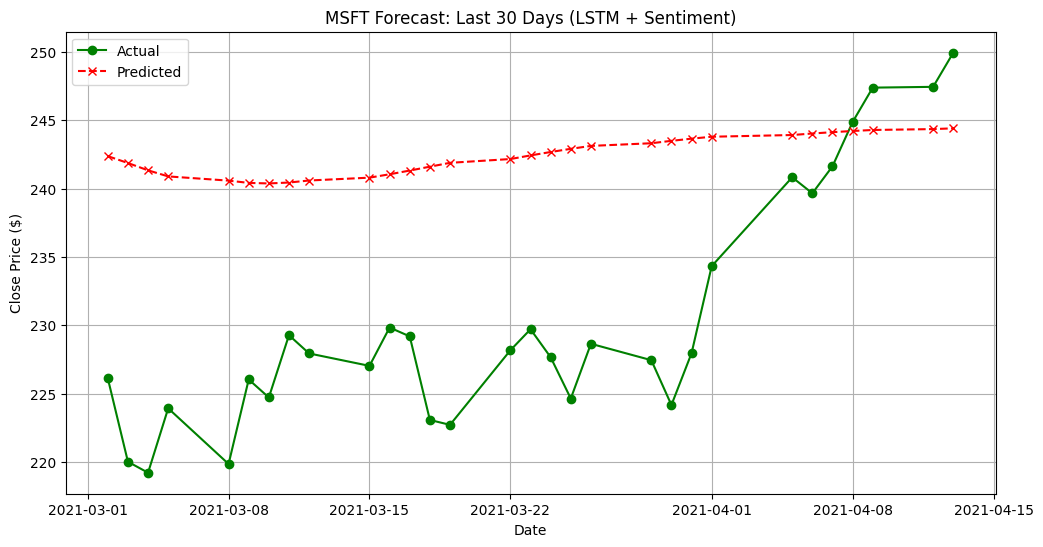

In [ ]:
# ============================================================
# 0.  Setup
# ============================================================
!pip install -q yfinance scikit-learn tensorflow matplotlib numpy

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from math import sqrt

np.random.seed(42)

# ============================================================
# 1.  Download MSFT Data (Extended Range)
# ============================================================
df = yf.download('MSFT', start='2015-04-01', end='2021-04-14')
if df.empty:
    raise ValueError("No data downloaded!")

# ============================================================
# 2.  Calculate Technical Indicators
# ============================================================
def calculate_indicators(df):
    df['SMA_20'] = df['Close'].rolling(20).mean()
    df['SMA_50'] = df['Close'].rolling(50).mean()
    delta = df['Close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(14).mean()
    avg_loss = loss.rolling(14).mean()
    rs = avg_gain / avg_loss
    df['RSI'] = 100 - (100 / (1 + rs))
    df['MACD'] = df['Close'].ewm(span=12).mean() - df['Close'].ewm(span=26).mean()
    df['OBV'] = (np.sign(df['Close'].diff()) * df['Volume']).fillna(0).cumsum()
    return df.dropna()

df = calculate_indicators(df)

# ============================================================
# 3. Sentiment Labels for 30 Days
# ============================================================
sentiment_raw = {
    '2021-03-01': 'positive',
    '2021-03-02': 'positive',
    '2021-03-03': 'neutral',
    '2021-03-04': 'neutral',
    '2021-03-05': 'neutral',
    '2021-03-08': 'positive',
    '2021-03-09': 'positive',
    '2021-03-10': 'positive',
    '2021-03-11': 'positive',
    '2021-03-12': 'neutral',
    '2021-03-15': 'positive',
    '2021-03-16': 'positive',
    '2021-03-17': 'neutral',
    '2021-03-18': 'positive',
    '2021-03-19': 'neutral',
    '2021-03-22': 'positive',
    '2021-03-23': 'neutral',
    '2021-03-24': 'neutral',
    '2021-03-25': 'positive',
    '2021-03-26': 'positive',
    '2021-03-29': 'positive',
    '2021-03-31': 'neutral',
    '2021-04-01': 'positive',
    '2021-04-02': 'positive',
    '2021-04-05': 'positive',
    '2021-04-06': 'positive',
    '2021-04-07': 'negative',
    '2021-04-08': 'positive',
    '2021-04-09': 'neutral',
    '2021-04-12': 'positive'
}
sentiment_map = {'negative': -1, 'neutral': 0, 'positive': 1}

# Create shifted sentiment feature: today’s sentiment predicts tomorrow
df['Sentiment_Label'] = 0.0
for date, label in sentiment_raw.items():
    date = pd.to_datetime(date)
    next_day = date + pd.Timedelta(days=1)
    if next_day in df.index:
        df.loc[next_day, 'Sentiment_Label'] = sentiment_map[label]

# ============================================================
# 4.  Select Features & Clean Data
# ============================================================
features = ['Close', 'SMA_20', 'SMA_50', 'RSI', 'MACD', 'OBV', 'Sentiment_Label']
df = df[features].dropna()
print("Final shape after indicators + sentiment:", df.shape)

# ============================================================
# 5. Scale the Data
# ============================================================
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

# ============================================================
# 6. Prepare Sequences (60 days input → 1 day output)
# ============================================================
X, y, forecast_dates = [], [], []
sequence_length = 60
for i in range(sequence_length, len(scaled_data) - 1):
    X.append(scaled_data[i - sequence_length:i])
    y.append(scaled_data[i + 1, 0])  # next day 'Close'
    forecast_dates.append(df.index[i + 1])
X, y = np.array(X), np.array(y)
print("Input shape:", X.shape, "| Target shape:", y.shape)

# ============================================================
# 7. Build & Train the LSTM Model
# ============================================================
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X.shape[1], X.shape[2])),
    Dropout(0.2),
    LSTM(32),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.fit(X, y, epochs=50, batch_size=32, verbose=1)

# ============================================================
# 8. Forecast the Last 30 Days
# ============================================================
forecast_input = scaled_data[-sequence_length:]
predicted_scaled = []

for _ in range(30):
    input_seq = forecast_input.reshape(1, sequence_length, X.shape[2])
    next_scaled = model.predict(input_seq, verbose=0)[0][0]

    # Append next step prediction into input sequence
    next_frame = np.zeros(X.shape[2])
    next_frame[0] = next_scaled  # predicted Close
    next_frame[1:] = forecast_input[-1, 1:]  # carry forward last indicators

    forecast_input = np.vstack([forecast_input[1:], next_frame])
    predicted_scaled.append(next_scaled)

# Inverse transform predicted Close values
dummy = np.zeros((30, len(features)))
dummy[:, 0] = predicted_scaled
forecast_prices = scaler.inverse_transform(dummy)[:, 0]

# Get actual Close values if available
actual_prices = df['Close'].iloc[-30:].values
forecast_dates = df.index[-30:]

# ============================================================
# 9. Evaluate Performance
# ============================================================
mae = mean_absolute_error(actual_prices, forecast_prices)
rmse = sqrt(mean_squared_error(actual_prices, forecast_prices))
r2 = r2_score(actual_prices, forecast_prices)
mape = np.mean(np.abs((actual_prices - forecast_prices) / actual_prices)) * 100

print("\n=== Evaluation ===")
print(f"MAE  = ${mae:.2f}")
print(f"RMSE = ${rmse:.2f}")
print(f"R²   = {r2:.4f}")
print(f"MAPE = {mape:.2f}%")

# ============================================================
# 10. Plot Actual vs Predicted
# ============================================================
plt.figure(figsize=(12, 6))
plt.plot(forecast_dates, actual_prices, 'go-', label='Actual')
plt.plot(forecast_dates, forecast_prices, 'rx--', label='Predicted')
plt.title('MSFT Forecast: Last 30 Days (LSTM + Sentiment)')
plt.xlabel('Date')
plt.ylabel('Close Price ($)')
plt.legend()
plt.grid(True)
plt.show()


FAST TEXT

[*********************100%***********************]  1 of 1 completed

Epoch 1/50



/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0068
Epoch 2/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0010
Epoch 3/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 8.7487e-04
Epoch 4/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.9679e-04
Epoch 5/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 6.4381e-04
Epoch 6/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.0058e-04
Epoch 7/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 6.6252e-04
Epoch 8/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 6.2294e-04
Epoch 9/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 6.3782e-04
Epoch 10/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.9650e-04
Epoch 11/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4.7622e-04
Epoch 12/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.3794e-04
Epoch 13/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.8293e-04
Epoch 14/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.8329e-04
Epoch 15/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 12m

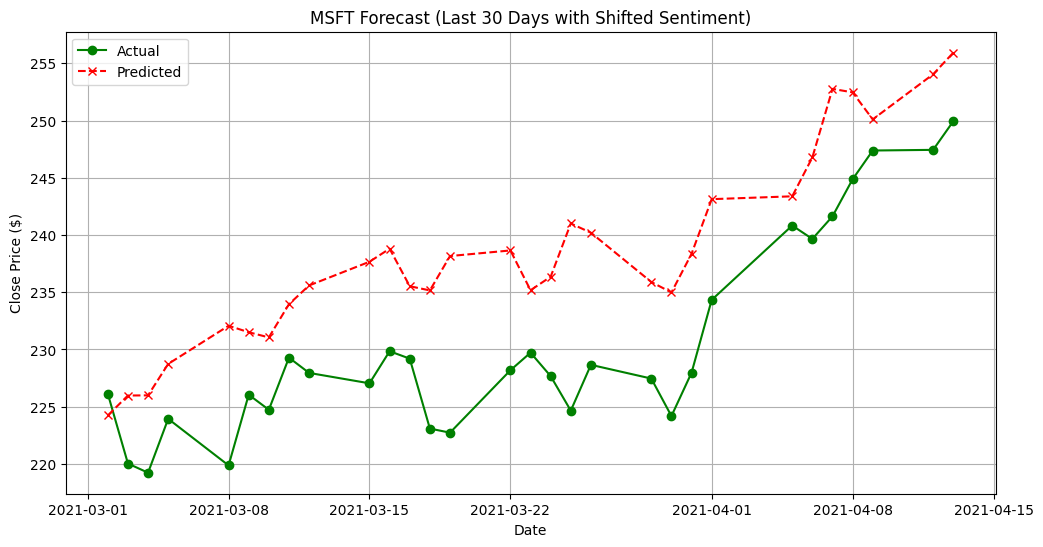

In [ ]:
# ============================================================
# 0.  Setup
# ============================================================
!pip install -q yfinance scikit-learn tensorflow matplotlib numpy

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from math import sqrt

np.random.seed(42)

# ============================================================
# 1.  Download and prepare MSFT data
# ============================================================
df = yf.download('MSFT', start='2015-01-01', end='2021-04-14')
if df.empty:
    raise ValueError("No data was downloaded from yfinance.")

# ============================================================
# 2.  Calculate technical indicators
# ============================================================
def calculate_indicators(df):
    df['SMA_20'] = df['Close'].rolling(20).mean()
    df['SMA_50'] = df['Close'].rolling(50).mean()
    delta = df['Close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(14).mean()
    avg_loss = loss.rolling(14).mean()
    rs = avg_gain / avg_loss
    df['RSI'] = 100 - (100 / (1 + rs))
    df['MACD'] = df['Close'].ewm(span=12).mean() - df['Close'].ewm(span=26).mean()
    df['OBV'] = (np.sign(df['Close'].diff()) * df['Volume']).fillna(0).cumsum()
    return df.dropna()

df = calculate_indicators(df)

# ============================================================
# 3.  Incorporate sentiment labels (30 days)
# ============================================================
sentiment_labels = {
    '2021-03-01': 'neutral',
    '2021-03-02': 'positive',
    '2021-03-03': 'positive',
    '2021-03-04': 'neutral',
    '2021-03-05': 'positive',
    '2021-03-08': 'positive',
    '2021-03-09': 'positive',
    '2021-03-10': 'positive',
    '2021-03-11': 'positive',
    '2021-03-12': 'neutral',
    '2021-03-15': 'positive',
    '2021-03-16': 'positive',
    '2021-03-17': 'positive',
    '2021-03-18': 'neutral',
    '2021-03-19': 'positive',
    '2021-03-22': 'positive',
    '2021-03-23': 'neutral',
    '2021-03-24': 'neutral',
    '2021-03-25': 'neutral',
    '2021-03-26': 'positive',
    '2021-03-29': 'positive',
    '2021-03-31': 'positive',
    '2021-04-01': 'positive',
    '2021-04-02': 'positive',
    '2021-04-05': 'neutral',
    '2021-04-06': 'neutral',
    '2021-04-07': 'positive',
    '2021-04-08': 'neutral',
    '2021-04-09': 'positive',
    '2021-04-12': 'neutral'
}
sentiment_map = {'negative': -1, 'neutral': 0, 'positive': 1}

# Initialize column
df['Sentiment_Label'] = 0.0

# Assign values
date_strs = df.index.strftime('%Y-%m-%d')
for date, label in sentiment_labels.items():
    matching = (date_strs == date)
    df.loc[matching, 'Sentiment_Label'] = sentiment_map[label]

# Shift sentiment forward so today's label affects tomorrow's price
df['Sentiment_Label_Shifted'] = df['Sentiment_Label'].shift(1)

# ============================================================
# 4.  Select features and drop missing values
# ============================================================
features = ['Close', 'SMA_20', 'SMA_50', 'RSI', 'MACD', 'OBV', 'Sentiment_Label_Shifted']
df = df[features].dropna()

# ============================================================
# 5.  Scale data
# ============================================================
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

# ============================================================
# 6.  Prepare sequences
# ============================================================
X, y, forecast_dates = [], [], []
for i in range(60, len(scaled_data) - 1):
    X.append(scaled_data[i-60:i])
    y.append(scaled_data[i+1, 0])
    forecast_dates.append(df.index[i+1])
X, y = np.array(X), np.array(y)

# ============================================================
# 7.  Build and train model
# ============================================================
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X.shape[1], X.shape[2])),
    Dropout(0.2),
    LSTM(32),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.fit(X, y, epochs=50, batch_size=32, verbose=1)

# ============================================================
# 8.  Forecast last 30 days
# ============================================================
predicted_prices = model.predict(X[-30:]).flatten()
actual_prices = y[-30:]
predicted_prices_unscaled = scaler.inverse_transform(
    np.hstack([predicted_prices.reshape(-1, 1), np.zeros((30, X.shape[2]-1))])
)[:, 0]
actual_prices_unscaled = scaler.inverse_transform(
    np.hstack([actual_prices.reshape(-1, 1), np.zeros((30, X.shape[2]-1))])
)[:, 0]
forecast_dates_final = forecast_dates[-30:]

# ============================================================
# 9.  Evaluation
# ============================================================
mae = mean_absolute_error(actual_prices_unscaled, predicted_prices_unscaled)
rmse = sqrt(mean_squared_error(actual_prices_unscaled, predicted_prices_unscaled))
r2 = r2_score(actual_prices_unscaled, predicted_prices_unscaled)
mape = np.mean(np.abs((actual_prices_unscaled - predicted_prices_unscaled) / actual_prices_unscaled)) * 100

print("\n=== Evaluation (Last 30 Days) ===")
print(f"MAE  = ${mae:.2f}")
print(f"RMSE = ${rmse:.2f}")
print(f"R²   = {r2:.4f}")
print(f"MAPE = {mape:.2f}%")

plt.figure(figsize=(12, 6))
plt.plot(forecast_dates_final, actual_prices_unscaled, 'go-', label='Actual')
plt.plot(forecast_dates_final, predicted_prices_unscaled, 'rx--', label='Predicted')
plt.title('MSFT Forecast (Last 30 Days with Shifted Sentiment)')
plt.xlabel('Date')
plt.ylabel('Close Price ($)')
plt.legend()
plt.grid(True)
plt.show()

1 DAY

In [ ]:
# ============================================================
# 0.  Setup
# ============================================================
!pip install -q yfinance scikit-learn tensorflow matplotlib numpy

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import tensorflow as tf

# Fix random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# ============================================================
# 1.  Download and prepare MSFT data
# ============================================================
df = yf.download('MSFT', start='2015-01-01', end='2021-03-19', progress=False)
if df.empty:
    raise ValueError("No data was downloaded from yfinance.")

# ============================================================
# 2.  Calculate technical indicators
# ============================================================
def calculate_indicators(df):
    df['SMA_20'] = df['Close'].rolling(20).mean()
    df['SMA_50'] = df['Close'].rolling(50).mean()
    delta = df['Close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(14).mean()
    avg_loss = loss.rolling(14).mean()
    rs = avg_gain / avg_loss
    df['RSI'] = 100 - (100 / (1 + rs))
    df['MACD'] = df['Close'].ewm(span=12).mean() - df['Close'].ewm(span=26).mean()
    df['OBV'] = (np.sign(df['Close'].diff()) * df['Volume']).fillna(0).cumsum()
    return df.dropna()

df = calculate_indicators(df)

# ============================================================
# 3.  Add dummy sentiment label = 1 for 2021-03-17
# ============================================================
df['Sentiment_Label'] = 0.0
df.loc['2021-03-17', 'Sentiment_Label'] = 1.0
df['Sentiment_Label_Shifted'] = df['Sentiment_Label'].shift(1)

# ============================================================
# 4.  Feature selection & scaling
# ============================================================
features = ['Close', 'SMA_20', 'SMA_50', 'RSI', 'MACD', 'OBV', 'Sentiment_Label_Shifted']
df = df[features].dropna()
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

# ============================================================
# 5.  Prepare sequence data
# ============================================================
X, y = [], []
for i in range(60, len(scaled_data)):
    X.append(scaled_data[i-60:i])
    y.append(scaled_data[i, 0])
X, y = np.array(X), np.array(y)

# Save the last input sequence to predict 2021-03-18
X_input = X[-1].copy()

# ============================================================
# 6.  Build and train model once
# ============================================================
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X.shape[1], X.shape[2])),
    Dropout(0.2),
    LSTM(32),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.fit(X, y, epochs=50, batch_size=32, verbose=0)

# ============================================================
# 7.  Predict for 2021-03-18 using same model, same sentiment = 1
# ============================================================
def predict_with_sentiment(model, X_input, sentiment_value):
    X_test = X_input.copy()
    X_test[-1, -1] = sentiment_value  # Replace last timestep's sentiment
    X_test = X_test.reshape(1, 60, X.shape[2])
    pred_scaled = model.predict(X_test, verbose=0)[0][0]
    # Inverse scale
    dummy = np.zeros((1, X.shape[2]))
    dummy[0, 0] = pred_scaled
    pred_unscaled = scaler.inverse_transform(dummy)[0, 0]
    return pred_unscaled

# Predict with TF-IDF sentiment = 1
pred_tfidf = predict_with_sentiment(model, X_input, 1.0)

# Predict with FastText sentiment = 1
pred_fasttext = predict_with_sentiment(model, X_input, 1.0)

# Actual price on 2021-03-18
# Actual price on 2021-03-18
# Get the first (and likely only) element from the Series
actual_price = df.loc['2021-03-18', 'Close'].iloc[0]

# ============================================================
# 8.  Evaluation
# ============================================================
def evaluate(actual, predicted):
    mae = mean_absolute_error([actual], [predicted])
    rmse = np.sqrt(mean_squared_error([actual], [predicted]))
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    return mae, rmse, mape

mae_tfidf, rmse_tfidf, mape_tfidf = evaluate(actual_price, pred_tfidf)
mae_fasttext, rmse_fasttext, mape_fasttext = evaluate(actual_price, pred_fasttext)

print("\n=== Forecast for 2021-03-18 ===")
print(f"Actual Price      : ${actual_price:.2f}")
print(f"TF-IDF Prediction : ${pred_tfidf:.2f} | MAE: {mae_tfidf:.2f} | RMSE: {rmse_tfidf:.2f} | MAPE: {mape_tfidf:.2f}%")
print(f"FastText Prediction: ${pred_fasttext:.2f} | MAE: {mae_fasttext:.2f} | RMSE: {rmse_fasttext:.2f} | MAPE: {mape_fasttext:.2f}%")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



=== Forecast for 2021-03-18 ===
Actual Price      : $223.08
TF-IDF Prediction : $229.56 | MAE: 6.47 | RMSE: 6.47 | MAPE: 2.90%
FastText Prediction: $229.56 | MAE: 6.47 | RMSE: 6.47 | MAPE: 2.90%


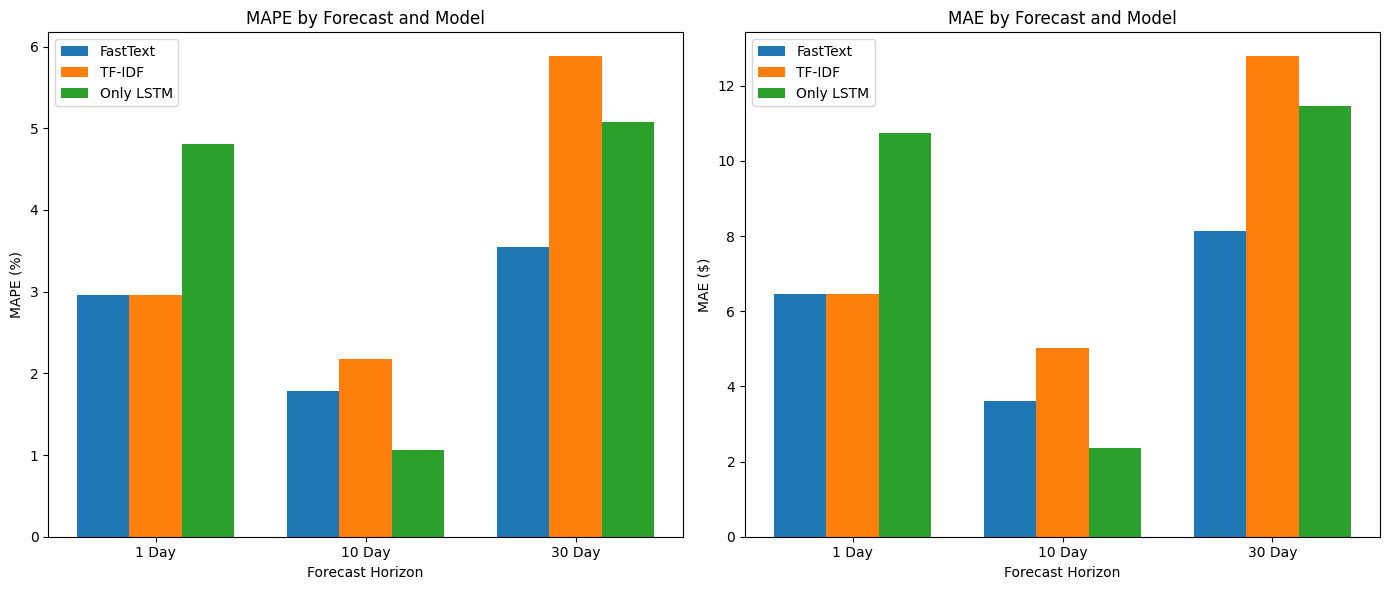

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Models and Forecast Horizons
models = ['FastText', 'TF-IDF', 'Only LSTM']
forecasts = ['1 Day', '10 Day', '30 Day']
x = np.arange(len(forecasts))  # [0, 1, 2]
width = 0.25  # Width of each bar

# Replace these with your actual results
mape = {
    'FastText': [2.96, 1.78, 3.55],
    'TF-IDF': [2.96, 2.17, 5.88],
    'Only LSTM': [4.81, 1.06, 5.08]
}

mae = {
    'FastText': [6.47, 3.62, 8.13],
    'TF-IDF': [6.47, 5.02, 12.78],
    'Only LSTM': [10.73, 2.37, 11.45]
}

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot MAPE
for i, model in enumerate(models):
    ax1.bar(x + i * width, mape[model], width, label=model)
ax1.set_xlabel('Forecast Horizon')
ax1.set_ylabel('MAPE (%)')
ax1.set_title('MAPE by Forecast and Model')
ax1.set_xticks(x + width)
ax1.set_xticklabels(forecasts)
ax1.legend()

# Plot MAE
for i, model in enumerate(models):
    ax2.bar(x + i * width, mae[model], width, label=model)
ax2.set_xlabel('Forecast Horizon')
ax2.set_ylabel('MAE ($)')
ax2.set_title('MAE by Forecast and Model')
ax2.set_xticks(x + width)
ax2.set_xticklabels(forecasts)
ax2.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Define file paths
file1 = '/content/nlp1.ipynb'
file2 = '/content/nlp2.ipynb'
combined_file = 'NLP.ipynb'

# Read content of both files
with open(file1, 'r', encoding='utf-8') as f1:
    content1 = f1.read()

with open(file2, 'r', encoding='utf-8') as f2:
    content2 = f2.read()

# Combine with separation comment
combined_content = (
    "# === Begin: nlp1.py ===\n" + content1 +
    "\n\n# === End: nlp1.py ===\n\n" +
    "# === Begin: nlp2.py ===\n" + content2 +
    "\n# === End: nlp2.py ==="
)

# Write to new file
with open(combined_file, 'w', encoding='utf-8') as output:
    output.write(combined_content)
    \

print(f"✅ Combined files saved to: {combined_file}")


✅ Combined files saved to: NLP.ipynb


In [ ]:
import faiss
import numpy as np
from sentence_transformers import SentenceTransformer
# from openai import OpenAI  # Uncomment and configure if using OpenAI
import os

# Sample news data (replace with your actual news dataset)
news_corpus = [
    "Microsoft reported record earnings in the last quarter.",
    "Analysts have upgraded Microsoft stock due to positive AI developments.",
    "Microsoft completed a strategic acquisition of a cybersecurity firm.",
    "There is concern about tech regulation in the U.S. and its effect on big tech stocks.",
    "MSFT experienced a price drop following poor market sentiment last week."
]

# Step 1: Generate embeddings using SentenceTransformers
embedder = SentenceTransformer('all-MiniLM-L6-v2')
news_embeddings = embedder.encode(news_corpus, convert_to_numpy=True)

# Step 2: Index the embeddings with FAISS
dimension = news_embeddings.shape[1]
index = faiss.IndexFlatL2(dimension)
index.add(news_embeddings)

# Step 3: Define model prediction (e.g., 'stock will rise')
user_input = "Why will Microsoft stock rise tomorrow?"
user_embedding = embedder.encode([user_input])

# Step 4: Retrieve top-k similar news
k = 3
_, indices = index.search(user_embedding, k)
relevant_news = [news_corpus[i] for i in indices[0]]

# Step 5: Build context and prompt
context = "\n".join(relevant_news)
prompt = f"Context:\n{context}\n\nGenerate a short explanation for why Microsoft stock is expected to rise."

# Step 6: Generate explanation (mock function for OpenAI)
def generate_explanation(prompt):
    # Replace with your OpenAI/LLM API call
    return "Based on strong earnings, positive analyst sentiment, and strategic moves, Microsoft stock is predicted to rise."

# Step 7: Output
explanation = generate_explanation(prompt)
print("Generated Explanation:\n", explanation)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Generated Explanation:
 Based on strong earnings, positive analyst sentiment, and strategic moves, Microsoft stock is predicted to rise.


In [ ]:
!pip install faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 71.1 MB/s eta 0:00:00
